In [66]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from dotenv import load_dotenv
load_dotenv()

# Initialize the LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

In [67]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

In [68]:
# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [69]:
def call_model(state:MessagesState, config:RunnableConfig, store:BaseStore):
    """ Load memory from the store and personalize chatbot response """

    user_id = config["configurable"]["user_id"]
    print(f"User ID: {user_id}")
    namespace = ("memory",user_id)
    print(f"Namespace: {namespace}")
    key = "user_memory"

    # exisiting_memory = store.get(namespace, key)
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."


    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {
        "messages": response
    }


In [70]:
def create_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """ Create or update memory based on the chat history """
    
    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    key = "user_memory"
    
    # Extract chat history
    chat_history = state["messages"]
    
    # Prepare the instruction with existing memory
    existing_memory = store.get(namespace, key)


      # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        exisiting_memory_content = existing_memory.value.get('memory')
    else:
        exisiting_memory_content = "No existing memory found."
    
    
    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=exisiting_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])
    
    
    store.put(namespace, key, {"memory": new_memory})

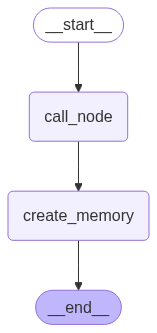

In [71]:
builder = StateGraph(MessagesState)
builder.add_node("call_node",call_model)
builder.add_node("create_memory", create_memory)
builder.set_entry_point("call_node")
builder.add_edge("call_node","create_memory")
builder.add_edge("create_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [72]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="Hi, my name is Lance")]
input_messages

events = graph.stream({"messages": input_messages}, config, stream_mode="values")

for event in events:
    print(event['messages'][-1])

content='Hi, my name is Lance' additional_kwargs={} response_metadata={} id='f9c6b4e2-6386-43c9-904e-5cba992534b6'
User ID: 1
Namespace: ('memory', '1')
content="Hello, Lance! It's great to meet you. How can I assist you today?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bkoc03NkfsfmcyeIJcBpxGt6PDOXJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--0bdd51cc-4b55-4a29-bb01-573ecb62ba3a-0' usage_metadata={'input_tokens': 62, 'output_tokens': 17, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [73]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
User ID: 1
Namespace: ('memory', '1')
================================== Ai Message ==================================

That sounds like a lot of fun, Lance! San Francisco has some great biking routes. Do you have a favorite trail or area you like to explore?


In [74]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's great to meet you. How can I assist you today?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun, Lance! San Francisco has some great biking routes. Do you have a favorite trail or area you like to explore?


In [75]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': AIMessage(content="- User's name is Lance.\n- Likes to bike around San Francisco.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 503, 'total_tokens': 518, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BkociRUV5dtb7s8kh1d0VoJvKQQoX', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c3e38668-d141-4639-89bd-9bd37fd6e39e-0', usage_metadata={'input_tokens': 503, 'output_tokens': 15, 'total_tokens': 518, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})},
 'created_at': '2025-06-21T09:16:25.061975+00:00',
 'updated_a

In [76]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
User ID: 1
Namespace: ('memory', '1')
================================== Ai Message ==================================

Hi Lance! Since you like biking around San Francisco, I recommend checking out the Golden Gate Park for a scenic ride. You could also explore the Marin Headlands for some challenging hills and stunning views of the Golden Gate Bridge. If you're up for a longer ride, the Bay Trail offers a great route along the waterfront. Enjoy your ride!
